In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy import stats

## Data Collection

In [9]:
df = pd.read_csv("../data/credit_risk_dataset.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None


In [10]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


## Data Cleaning & Preprocessing

### Missing Value Analysis

In [27]:
# Numerical filling with median and categorical filling with mode
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# Padding with median for numeric columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Filling with mode for categorical columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [28]:
print("\n Check Missing Values:\n", df.isnull().sum())


 Check Missing Values:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


### Outlier Detection and Correction (IQR, Z-score)

In [29]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] < lower) | (data[column] > upper)]

In [32]:
print("\nOutlier Detection:")
for col in num_cols:
    outliers = detect_outliers_iqr(df, col)
    if len(outliers) > 0:
        print(f"{col} in column {len(outliers)} outliers found.")
        # (winsorizing)
        Q1, Q3 = df[col].quantile([0.05, 0.95])
        df[col] = np.clip(df[col], Q1, Q3)


Outlier Detection:
loan_amnt in column 1689 outliers found.
loan_status in column 7108 outliers found.


### Duplicate Control

In [33]:
dup_count = df.duplicated().sum()
print(f"\nDuplicated Count: {dup_count}")
if dup_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicated values removed.")


Duplicated Count: 196
Duplicated values removed.


### Encoding Categorical Variables

In [34]:
le = LabelEncoder()
for col in cat_cols:
    if df[col].nunique() <= 5:
        df[col] = le.fit_transform(df[col])

# One-Hot Encoding for multi-category variables
df = pd.get_dummies(df, columns=[col for col in cat_cols if df[col].nunique() > 5], drop_first=True)

print("\nCategorical variables were encoded.")



Categorical variables were encoded.


### Feature Scaling

In [35]:
scaler = StandardScaler()
scaled_cols = df.select_dtypes(include=np.number).columns

df[scaled_cols] = scaler.fit_transform(df[scaled_cols])
print("\nFeature scaling completed.")


Feature scaling completed.


## EDA - Exploratory Data Analysis

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

### Class Distribution

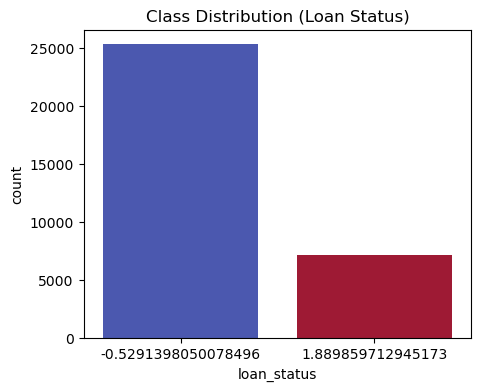


Distribution:
 loan_status
-0.52914    0.781257
 1.88986    0.218743
Name: proportion, dtype: float64


In [54]:
plt.figure(figsize=(5,4))
sns.countplot(x='loan_status', data=df, palette='coolwarm', legend=False, hue='loan_status')
plt.title("Class Distribution (Loan Status)")
plt.show()
print("\nDistribution:\n", df['loan_status'].value_counts(normalize=True))

### Distributions of Numerical Variables

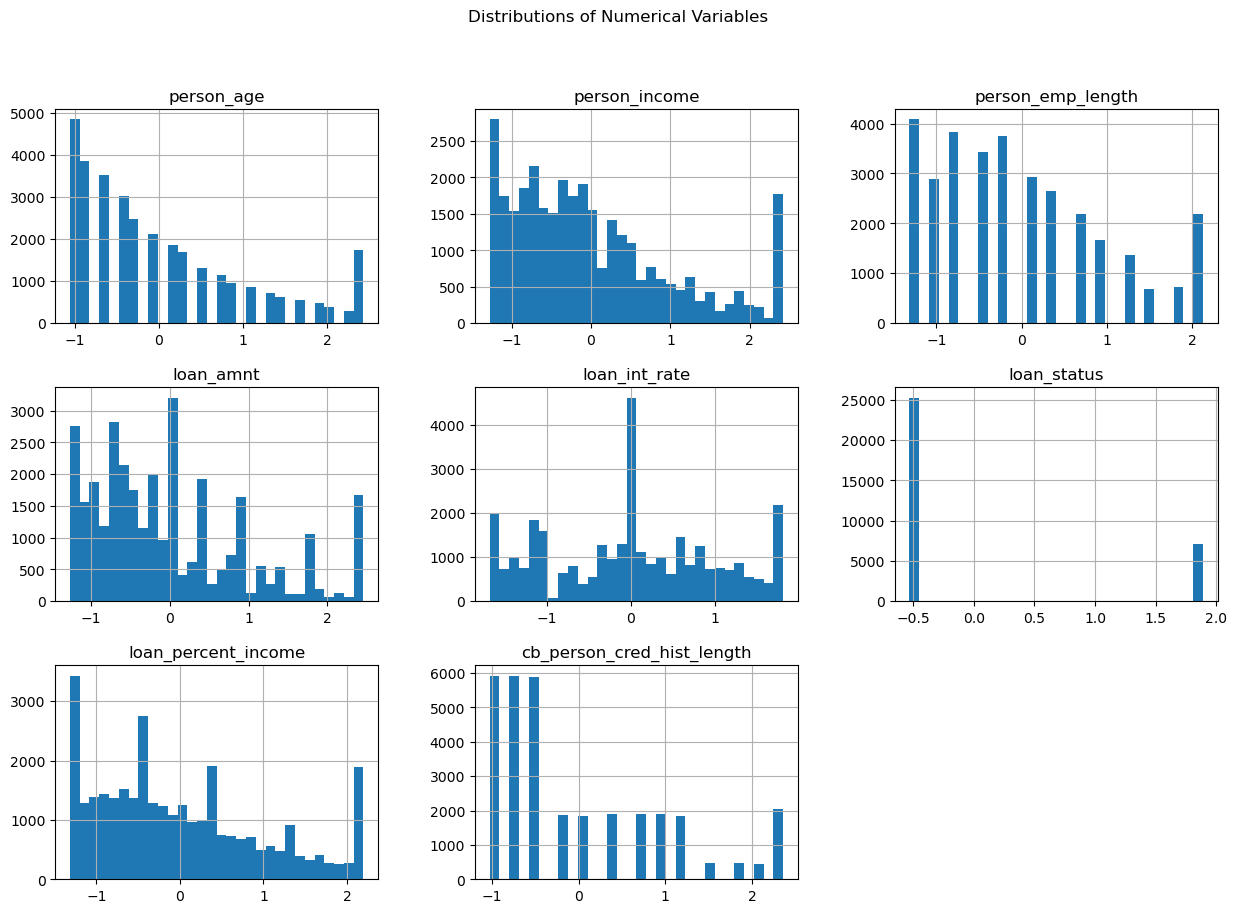

In [56]:
df[num_cols].hist(bins=30, figsize=(15,10))
plt.suptitle("Distributions of Numerical Variables")
plt.show()

### Outlier Visualization with Boxplot

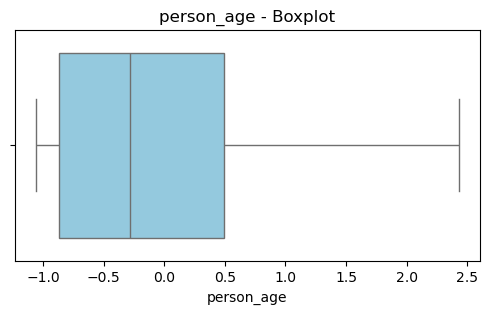

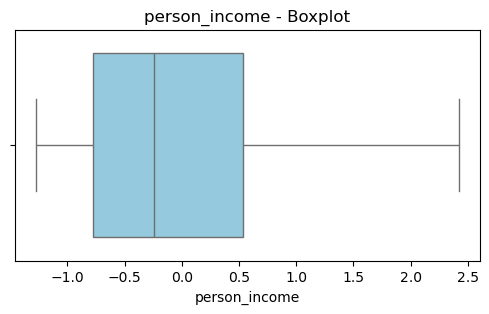

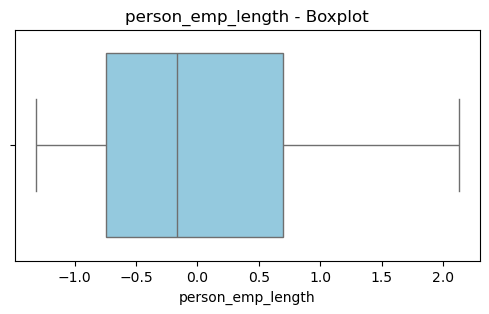

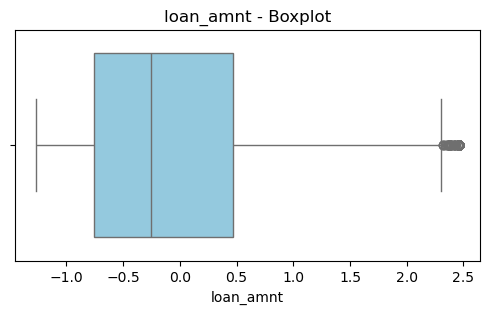

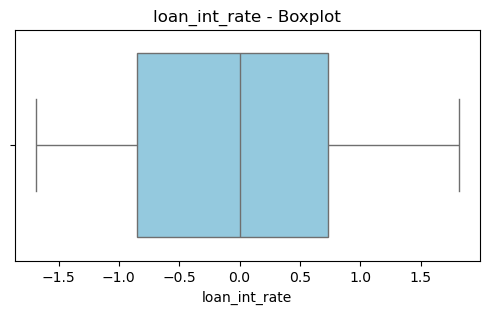

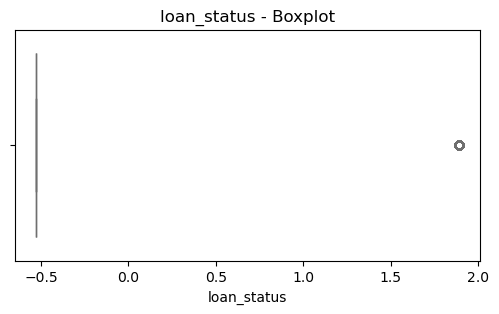

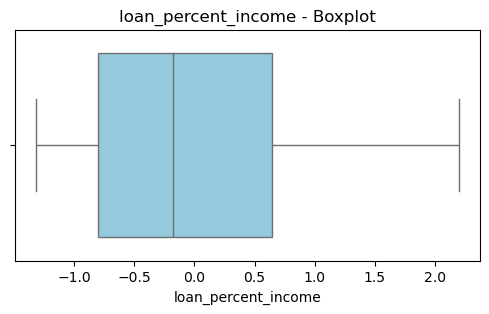

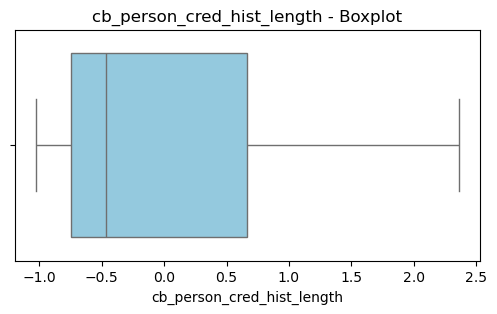

In [58]:


for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} - Boxplot")
    plt.show()

### Correlation Matrix

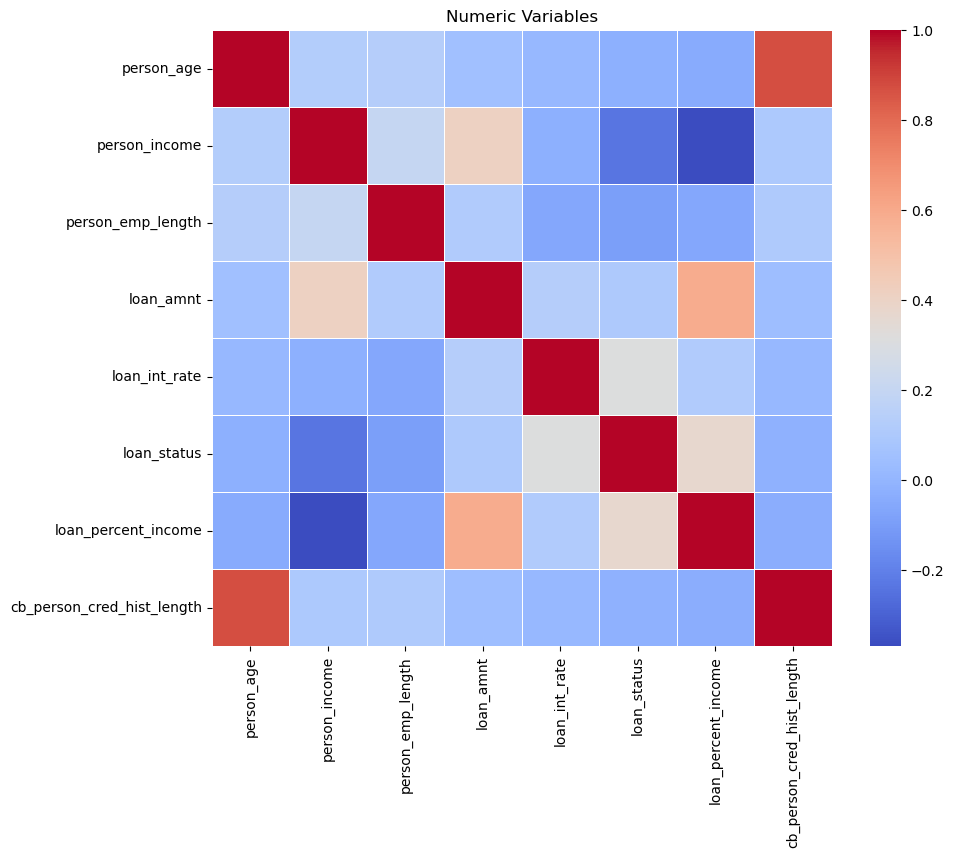

In [61]:
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Numeric Variables")
plt.show()

## Feature Selection + Modelling

In [87]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]


In [88]:
X = pd.get_dummies(X, drop_first=True)

In [89]:
y.value_counts()
y.dtype

dtype('int32')

In [90]:
df['loan_status'] = df['loan_status'].round().astype(int)

In [91]:
print(df['loan_status'].value_counts())
print(df['loan_status'].dtype)

loan_status
0    25301
1     7084
Name: count, dtype: int64
int32


In [93]:
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Selected Most Important Features:")
print(selected_features)



X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)


Selected Most Important Features:
Index(['person_income', 'person_home_ownership', 'person_emp_length',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'loan_grade_B', 'loan_grade_D',
       'loan_grade_E'],
      dtype='object')


In [95]:
# K-Fold

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

In [96]:
# Grid Search Parameters

param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "Decision Tree": {"max_depth": [3, 5, 7, None], "min_samples_split": [2, 5, 10]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [5, 10, None]},
    "Gradient Boosting": {"learning_rate": [0.01, 0.1, 0.2], "n_estimators": [100, 200]}
}

In [97]:
# Model Training + K-Fold + Grid Search

best_models = {}
for name, model in models.items():
    print(f"\n🚀 {name} model training...")
    grid = GridSearchCV(model, param_grids[name], cv=kfold, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    print(f"Best parameters: {grid.best_params_}")
    print(f"CV ROC-AUC Score: {grid.best_score_:.4f}")


🚀 Logistic Regression model training...
Best parameters: {'C': 0.1}
CV ROC-AUC Score: 0.8461

🚀 Decision Tree model training...
Best parameters: {'max_depth': 7, 'min_samples_split': 10}
CV ROC-AUC Score: 0.8851

🚀 Random Forest model training...
Best parameters: {'max_depth': None, 'n_estimators': 200}
CV ROC-AUC Score: 0.9097

🚀 Gradient Boosting model training...
Best parameters: {'learning_rate': 0.2, 'n_estimators': 200}
CV ROC-AUC Score: 0.9292


## Evalution 

In [98]:
for name, model in best_models.items():
    print(f"\n📈 {name} - Results")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print("-" * 40)


📈 Logistic Regression - Results
Accuracy: 0.8522
Precision: 0.7371
Recall: 0.5046
F1 Score: 0.5991
ROC-AUC: 0.8473
----------------------------------------

📈 Decision Tree - Results
Accuracy: 0.8979
Precision: 0.9038
Recall: 0.5970
F1 Score: 0.7191
ROC-AUC: 0.8864
----------------------------------------

📈 Random Forest - Results
Accuracy: 0.9063
Precision: 0.8750
Recall: 0.6669
F1 Score: 0.7569
ROC-AUC: 0.9165
----------------------------------------

📈 Gradient Boosting - Results
Accuracy: 0.9084
Precision: 0.8801
Recall: 0.6733
F1 Score: 0.7629
ROC-AUC: 0.9297
----------------------------------------


In [99]:
### Gradient Boosting provided the best balance on this dataset—the most powerful model with high accuracy, good recall, and excellent ROC-AUC scores.

## LGD - EAD - Expected Loss (EL) Calculations 

Total Expected Loss: 1069.53
Average Expected Loss: 0.03
Average EL / EAD ratio: 335987965546354.0

Average Expected Loss by Loan Type:
loan_intent_type
OTHER              0.041652
PERSONAL           0.033905
VENTURE            0.033045
EDUCATION          0.032123
HOMEIMPROVEMENT    0.029138
MEDICAL            0.028069
Name: EL, dtype: float64


C:\Users\berka\AppData\Local\Temp\ipykernel_12756\2691022854.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=el_by_intent.index, y=el_by_intent.values, palette="viridis")


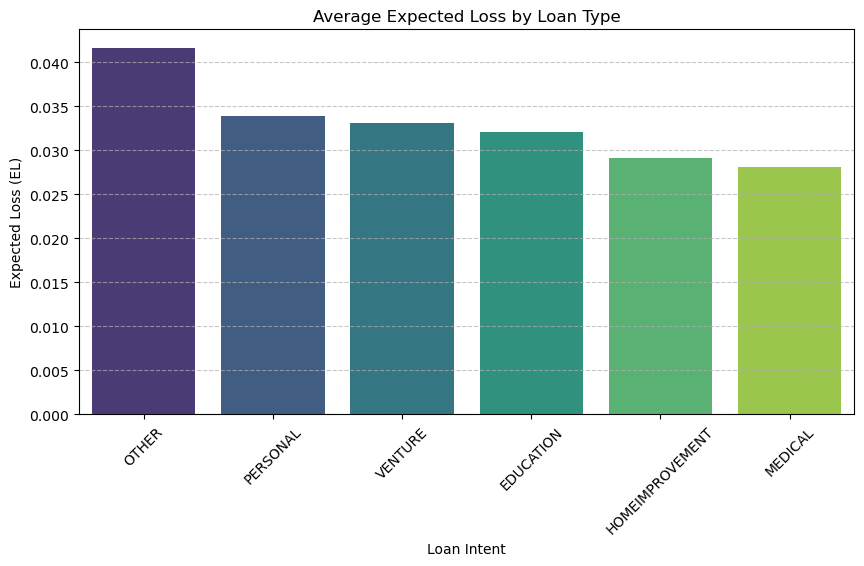

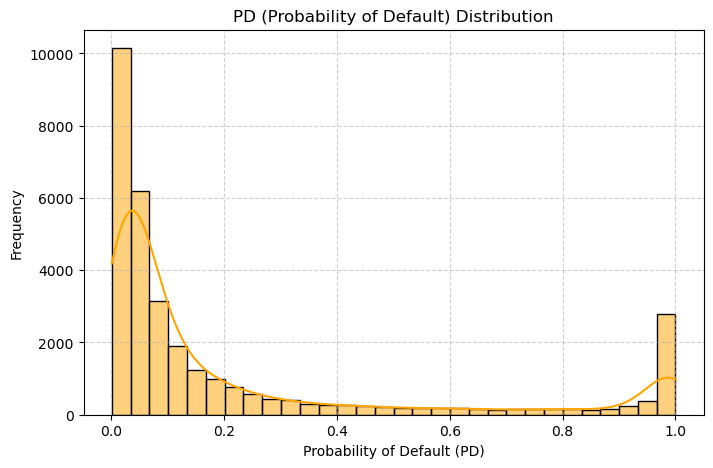

In [109]:
# PD: Probability of Default already predicted by the model
# df['PD'] = model.predict_proba(X_selected)[:, 1]  # if already predicted, no need

# EAD: Exposure at Default (loan amount at risk)
df['EAD'] = df['loan_amnt']

# LGD: Loss Given Default based on one-hot encoded loan_intent columns
lgd_map = {
    'loan_intent_PERSONAL': 0.85,
    'loan_intent_EDUCATION': 0.85,
    'loan_intent_HOMEIMPROVEMENT': 0.60,
    'loan_intent_MEDICAL': 0.60,
    'loan_intent_VENTURE': 0.90
}

# Function: assign LGD based on active loan_intent for each row
def compute_lgd(row):
    for col, lgd_val in lgd_map.items():
        if col in row and row[col] == 1:
            return lgd_val
    # If no match found, use average LGD
    return np.mean(list(lgd_map.values()))

df['LGD'] = df.apply(compute_lgd, axis=1)

# Expected Loss (EL) calculation
df['EL'] = df['PD'] * df['LGD'] * df['EAD']

# Overall EL statistics
print("Total Expected Loss:", round(df['EL'].sum(), 2))
print("Average Expected Loss:", round(df['EL'].mean(), 2))
print("Average EL / EAD ratio:", round(df['EL'].mean() / df['EAD'].mean(), 4))

# Average EL by loan type
# Function to determine which loan_intent is active for each row
def get_loan_intent(row):
    for col in lgd_map.keys():
        if row[col] == 1:
            return col.replace('loan_intent_', '')
    return 'OTHER'

df['loan_intent_type'] = df.apply(get_loan_intent, axis=1)
el_by_intent = df.groupby('loan_intent_type')['EL'].mean().sort_values(ascending=False)
print("\nAverage Expected Loss by Loan Type:")
print(el_by_intent)

# Visualization: Average EL by loan type
plt.figure(figsize=(10,5))
sns.barplot(x=el_by_intent.index, y=el_by_intent.values, palette="viridis")
plt.title('Average Expected Loss by Loan Type')
plt.ylabel('Expected Loss (EL)')
plt.xlabel('Loan Intent')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# PD distribution plot
plt.figure(figsize=(8,5))
sns.histplot(df['PD'], bins=30, kde=True, color='orange')
plt.title('PD (Probability of Default) Distribution')
plt.xlabel('Probability of Default (PD)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
